In [2]:
import itertools
from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neighbors import NearestNeighbors

# import node2vec

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx

from utils import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
nodes_df = pd.read_csv('data/road_intersection_nodes.csv')
nodes_df

,lng,lat,id
0,-74.017931,40.706175,0
1,-74.017869,40.706349,1
2,-74.017789,40.706519,2
3,-74.017690,40.706683,3
4,-74.017574,40.706840,4
...,...,...,...
236253,-73.901365,40.663609,2414372
236254,-73.951336,40.742705,2414375
236255,-73.951368,40.742617,2414376
236256,-73.951404,40.742530,2414377


In [4]:
# convert decimals to radiands
nodes_df[['lng', 'lat']] = nodes_df[['lng', 'lat']].apply(radians)
nodes_df.head()

,lng,lat,id
0,-1.291857,0.710457,0
1,-1.291856,0.710460,1
2,-1.291854,0.710463,2
3,-1.291852,0.710466,3
4,-1.291850,0.710468,4


In [5]:
# computing center of region
lat_center, lng_center = nodes_df.lat.mean(), nodes_df.lng.mean()
lat_center, lng_center

(0.7106174200098879, -1.290224335366838)

Due computational complexity, I consider only region with a radius of RADIUS around (lat_center, lng_center).

In [6]:
RADIUS = 8

considered_nodes_df = nodes_df[haversine(lng_center, lat_center, nodes_df.lng, nodes_df.lat) <= RADIUS]
considered_nodes_set = set(considered_nodes_df.id.unique())

In [7]:
pickups_df = pd.read_csv('data/TLC_daily.csv')
pickups_df = pickups_df[pickups_df['id'].isin(considered_nodes_set)]
pickups_df

,day,id,pickups
0,1.0,0,19.0
1,1.0,1,18.0
2,1.0,2,18.0
3,1.0,3,17.0
4,1.0,4,13.0
...,...,...,...
35911210,152.0,2414253,0.0
35911211,152.0,2414254,0.0
35911212,152.0,2414267,0.0
35911213,152.0,2414268,0.0


In [8]:
edges_df = pd.read_csv('data/road_intersection_edges.csv')
edges_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282983 entries, 0 to 282982
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   olng    282983 non-null  float64
 1   olat    282983 non-null  float64
 2   dlng    282983 non-null  float64
 3   dlat    282983 non-null  float64
 4   oid     282983 non-null  int64  
 5   did     282983 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 13.0 MB


In [9]:
considered_edges_df = edges_df[edges_df.oid.isin(considered_nodes_set) & edges_df.did.isin(considered_nodes_set)]
# computing edges weights in km
considered_edges_df['dist'] = considered_edges_df.apply(lambda x: haversine(x['olng'], x['olat'], x['dlng'], x['dlat']), axis=1).astype(float)

/tmp/ipykernel_23567/2139661312.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  considered_edges_df['dist'] = considered_edges_df.apply(lambda x: haversine(x['olng'], x['olat'], x['dlng'], x['dlat']), axis=1).astype(float)


In [10]:
G = make_graph_from_df(considered_nodes_df, considered_edges_df)
G.number_of_nodes(), G.number_of_edges()

(60789, 75647)

To search for node embeddings I use node2vec approach. I tried to use network SVD from network-sklearn, but it didn't work well (I got very low scaled vectors with values about 1e-20). node2vec gives more pleasant embeddings in terms of using dot product or cosine similarity. By the way it's not so fast (model trains for 3,5 minutes for graph with 60k vertices and 75k edges with some hyperparameters tuning)

In [11]:
%%time

# embeddings = generate_node_embeddings(G)
# embeddings.save('model_data/embeddings.data')

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


In [12]:
embeddings = load_embeddings('model_data/embeddings.data')

In [13]:
for idx, e in enumerate(G.edges()):
    if idx == 5:
        break
    print(e)

(0, 1)
(0, 24)
(0, 350192)
(1, 2)
(2, 3)


In [14]:
embeddings.wv.most_similar('0')

[('1', 0.9907424449920654),
 ('350192', 0.9844527244567871),
 ('24', 0.9769642353057861),
 ('2', 0.9732216000556946),
 ('200921', 0.9553194046020508),
 ('350191', 0.94412761926651),
 ('3', 0.9407243728637695),
 ('332388', 0.9193974733352661),
 ('200923', 0.9148669838905334),
 ('350190', 0.9080977439880371)]

In [15]:
# join embeddings with corresponding nodes (as x feature)
for idx, node in enumerate(G.nodes()):
    G.add_node(int(node), x=embeddings.wv[str(node)].copy())

In [16]:
# Torch dataset. Used primary for batch training.

class DayObservationsDataset(Dataset):
    def __init__(self, pickups_df: pd.DataFrame) -> None:
        super().__init__()
        self.data = pickups_df['id'].to_numpy()
        self.targets = pickups_df['pickups'].to_numpy()
        self.observed_nodes = set(np.unique(self.data))

        self.node_to_target = pickups_df.set_index('id')['pickups'].to_dict()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def get_observation_by_node(self, node):
        return self.node_to_target[node]

    def get_observed_nodes(self):
        return self.observed_nodes


def make_dataset_by_day(pickups_df, day):
    df = pickups_df[pickups_df['day'].astype('int') == day].copy()
    df.drop('day', axis=1, inplace=True)
    return DayObservationsDataset(df)


ds = make_dataset_by_day(pickups_df, 20)
len(ds)

60789

In [17]:
# train-val-test split

np.random.seed(228)

indices = list(range(len(ds)))

train_indices, test_indices = train_test_split(indices, test_size=0.3)
train_indices, val_indices = train_test_split(train_indices, test_size=0.3)
print(len(train_indices), len(val_indices), len(test_indices))

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)


train_loader = DataLoader(ds, batch_size=128, sampler=train_sampler)
val_loader = DataLoader(ds, batch_size=len(val_sampler.indices), sampler=val_sampler)
test_loader = DataLoader(ds, batch_size=len(test_sampler.indices), sampler=test_sampler)

29786 12766 18237


In [18]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [19]:
# Pytorch geometric Data object. For now used only for storing node embedding. 
# Supposed to be used in the future for obtaining node embeddings.
pyg_graph = from_networkx(G)
pyg_graph.to(device)

/home/eldervald/miniconda3/envs/traffic/lib/python3.9/site-packages/torch_geometric/utils/convert.py:170: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/torch/csrc/utils/tensor_new.cpp:201.)
  data[key] = torch.tensor(value)


Data(x=[60789, 128], edge_index=[2, 151294], lng=[60789], lat=[60789], id=[60789], dist=[151294])

$$T(a) = \sum_{b \neq a,\space b\subset Train } T(b)w(a, b), \textrm{where summation is calculated for the {\bf k} nearest neighbors.}$$

$ w(a,b)= k \frac{u(a,b)}{\sum_{b \neq a} u(a, b)}  + (1-k) \frac{g(a,b)}{\sum_{b \neq a} g(a,b)};$

$u(a, b) = exp(-\lambda_1 d(a, b));$

$g(a, b) = exp(-\lambda_2 similarity(x_a, x_b)) \textrm{, where similarity is cosine distance} $

$x_a \textrm{ is embedding for node {\bf a}}$

In [20]:
def weight_fn(dists, lamb):
    return torch.exp(-lamb * dists)


class Estimator(nn.Module):
    def __init__(self, pyg_graph: pyg.data.Data, observations: Tuple[List, List]) -> None:
        super().__init__()

        self.g = pyg_graph
        self.obs_nodes = observations[0]
        self.obs_targets = observations[1]

        self.NEIGHBORS_NUM = 15
        
        # dicts for fast indexing
        self.node_to_gidx = np.vectorize(dict(zip(self.g.id.detach().cpu().numpy(), range(len(self.g.id)))).get)
        
        self.neighbors = NearestNeighbors(n_neighbors=self.NEIGHBORS_NUM, metric='haversine')
        obs_nodes_indices = self.node_to_gidx(self.obs_nodes)
        self.neighbors.fit(torch.vstack([self.g.lat[obs_nodes_indices], self.g.lng[obs_nodes_indices]]).T.detach().cpu())

        self.k = nn.Parameter(torch.rand(1))
        # self.k = torch.tensor([1.0])
        self.lambda_1 = nn.Parameter(torch.rand(1))
        self.lambda_2 = nn.Parameter(torch.rand(1))

    def forward(self, X):
        # getting nearest observed nodes
        X_indices = self.node_to_gidx(X.detach().cpu())
        dists, indices = self.neighbors.kneighbors(torch.vstack([self.g.lat[X_indices], self.g.lng[X_indices]]).T.detach().cpu())
        # converting dists to meters
        dists = dists * 6371 * 1000

        # skipping loc by itself
        if self.training:
            dists, indices = dists[:, 1:], indices[:, 1:]

        observations = self.obs_targets[indices]

        dists, observations = torch.as_tensor(dists).to(device), torch.as_tensor(observations).to(device)

        # finding corresponding node embedding of neighbors
        neighbors_indices = self.node_to_gidx(self.obs_nodes[indices])
        neighbors_embeds = self.g.x[neighbors_indices.reshape(-1)].reshape(*neighbors_indices.shape, -1)

        # computing similarities between node ans its neighbors
        X_embeds = self.g.x[X_indices]
        similarities = nn.functional.cosine_similarity(X_embeds[:, None], neighbors_embeds, dim=2)

        dist_weights = weight_fn(dists, self.lambda_1)
        simi_weights = weight_fn(similarities, self.lambda_2)

        # sum normalizization
        dist_weights = nn.functional.normalize(dist_weights, p=1)
        simi_weights = nn.functional.normalize(simi_weights, p=1)

        att_weights = self.k * dist_weights + (1 - self.k) * simi_weights

        # interpolation
        result = torch.sum(att_weights.mul(observations), dim=-1)

        return result

estimator = Estimator(pyg_graph, ds[train_indices]).to(device)
# kek = next(iter(train_loader))
# estimator(kek[0])[:20], kek[1][:20] 

Note: I tried MSE and Huber losses, and I got very vary results (Huber(20) ~ 40-60, MSE ~ 200). -> maybe there are a lot of outliers in data.

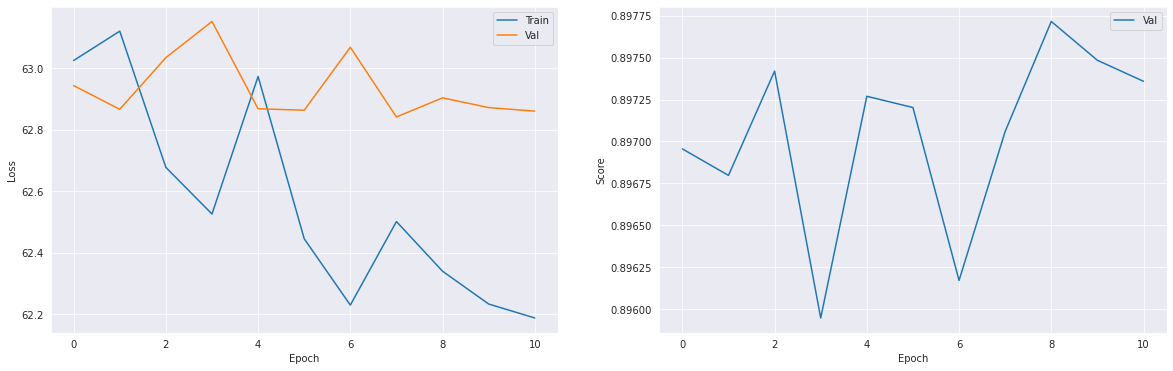

k Parameter containing:
tensor([0.9512], device='cuda:0', requires_grad=True)
lambda_1 Parameter containing:
tensor([0.1144], device='cuda:0', requires_grad=True)
lambda_2 Parameter containing:
tensor([-1.5970], device='cuda:0', requires_grad=True)
Test loss: 59.111554562795014, test score: 0.8646457723823597


In [21]:
loss_fn = nn.HuberLoss(delta=20).to(device)
# loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(estimator.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.7)


def calc_score(pred, actual):
    return r2_score(actual, pred)

def test(model, loader) -> Tuple[float, float]:
    # returns average loss and score
    model.eval()

    scores = []
    total_loss = 0

    with torch.no_grad():
        for (X, y) in loader:
            X_gpu = X.to(device)
            y_gpu = y.to(device)
            out = model(X_gpu)
            scores.append(calc_score(out.detach().cpu(), y))
            loss = loss_fn(out, y_gpu)
            total_loss += loss.item()
    
    return total_loss / len(loader), np.mean(scores)


def train(model, train_loader, val_loader, loss_fn, optimizer, scheduler=None, num_epochs=10, plotting=True):
    train_losses = []
    val_losses = []
    val_scores = []
    

    for epoch in range(num_epochs + 1):
        model.train()
        total_loss = 0

        for i_step, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            X_gpu = X.to(device)
            y_gpu = y.to(device)
            out = model(X_gpu)
            loss = loss_fn(out, y_gpu)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        if scheduler is not None:
            scheduler.step()

        val_loss, score = test(model, val_loader)
        val_losses.append(val_loss)
        val_scores.append(score)

        if plotting and epoch > 0:
            clear_output(True)
            _, axes = plt.subplots(1, 2, figsize=(20, 6))
            
            sns.lineplot(ax=axes[0], x=range(epoch + 1), y=train_losses, label='Train')
            sns.lineplot(ax=axes[0], x=range(epoch + 1), y=val_losses, label='Val')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()

            sns.lineplot(ax=axes[1], x=range(epoch + 1), y=val_scores, label='Val')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Score')
            axes[1].legend()

            plt.show()
            # print(f'Epoch {epoch}, Loss: {train_losses[-1]:.4f}, Val loss: {val_loss:.4f}, Val R2: {val_scores[-1]:.4f}')

train(estimator, train_loader, val_loader, loss_fn, optimizer, scheduler)

for name, param in estimator.named_parameters():
    print(name, param)

test_loss, test_score = test(estimator, test_loader)
print(f'Test loss: {test_loss}, test score: {test_score}')